# Utility functions

In [1]:
import os,glob,warnings,time,sys,itertools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import ndimage
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
if __name__ == "__main__":
    _sInfo = sys.version_info
    print ("Python version is [%d.%d%d]"%(_sInfo[0],_sInfo[1],_sInfo[2]))
    print ("TensorFlow version is [%s]."%(tf.__version__))

Python version is [3.52]
TensorFlow version is [1.10.0].


### Normalizer

In [2]:
class nzr(object):
    def __init__(self,_rawdata,_eps=1e-8):
        self.rawdata = _rawdata
        self.eps     = _eps
        self.mu      = np.mean(self.rawdata,axis=0)
        self.std     = np.std(self.rawdata,axis=0)
        self.nzd_data = self.get_nzdval(self.rawdata)
        self.org_data = self.get_orgval(self.nzd_data)
        self.maxerr = np.max(self.rawdata-self.org_data)
    def get_nzdval(self,_data):
        _n = _data.shape[0]
        _nzddata = (_data - np.tile(self.mu,(_n,1))) / np.tile(self.std+self.eps,(_n,1))
        return _nzddata
    def get_orgval(self,_data):
        _n = _data.shape[0]
        _orgdata = _data*np.tile(self.std+self.eps,(_n,1))+np.tile(self.mu,(_n,1))
        return _orgdata
# Demo usage of normalizer
if __name__=='__main__':
    np.set_printoptions(precision=3) # Set precision
    xRand = 100*np.random.rand(100,2)
    print ("Mean and varaince of original X are %s and %s"
               %(np.mean(xRand,axis=0),np.var(xRand,axis=0)))
    nzrX = nzr(_rawdata=xRand) # Noarmalizer
    nzdX = nzrX.get_nzdval(xRand) # Normalize 
    print ("Mean and varaince of normalized X are %s and %s"
               %(np.mean(nzdX,axis=0),np.var(nzdX,axis=0)))

Mean and varaince of original X are [47.838 46.817] and [846.971 916.441]
Mean and varaince of normalized X are [ 3.797e-16 -4.530e-16] and [1. 1.]


### MNIST Loader

In [3]:
def load_mnist():
    mnist = input_data.read_data_sets('../data/', one_hot=True)
    trainimg,trainlabel = mnist.train.images,mnist.train.labels
    testimg,testlabel = mnist.test.images,mnist.test.labels
    valimg,vallabel = mnist.validation.images,mnist.validation.labels
    return trainimg,trainlabel,testimg,testlabel,valimg,vallabel
# Demo usage of mnist loader
if __name__=='__main__':
    trainimg,trainlabel,testimg,testlabel,valimg,vallabel = load_mnist()
    print ("We have [%d] train, [%d] test, and [%d] validation images."
           %(trainimg.shape[0],testimg.shape[0],valimg.shape[0]))

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../data/t10k-images-idx3-ubyte.gz
Extracting ../data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
We have [55000] train, [10000] test, and [5000] validation images.


### Load MNIST with Noise

In [4]:
def load_mnist_with_noise(_errType='rs',_outlierRatio=0.00,_seed=0):
    # Load MNIST 
    trainimg,trainlabel,testimg,testlabel,valimg,vallabel = load_mnist()
    if _outlierRatio == 0:
        return trainimg,trainlabel,testimg,testlabel,valimg,vallabel
    
    # Add outliers 
    if _errType == 'rs': # Random Shuffle
        np.random.seed(seed=_seed); 
        outlierRatio = _outlierRatio
        nOutlier = (int)(outlierRatio*trainimg.shape[0])
        oIdx = np.random.permutation(trainimg.shape[0])[:nOutlier]
        trainlabel[oIdx,:] = np.eye(10)[np.random.choice(10,nOutlier)]
    elif _errType == 'rp':# Random Perturbation (from Reed)
        _outlierRatio /= 2.0 # For random perturbation, half the error ratio! 
        perm = np.array([7, 9, 0, 4, 2, 1, 3, 5, 6, 8])
        X_train,y_train = trainimg,np.argmax(trainlabel,axis=1)
        noise = perm[y_train]
        from sklearn.model_selection import StratifiedShuffleSplit
        _, noise_idx = next(iter(StratifiedShuffleSplit(n_splits=1,
                            test_size=_outlierRatio,
                            random_state=_seed).split(X_train,y_train)))
        y_train_noise = y_train.copy() 
        y_train_noise[noise_idx] = noise[noise_idx]
        trainlabel = np.eye(10)[y_train_noise]
    elif _errType == 'b': # biased
        _outlierRatio /= 2.0 # For biased perturbation, half the error ratio! 
        np.random.seed(seed=_seed); 
        nTrain = trainlabel.shape[0]
        nOutlier = (int)(nTrain*_outlierRatio)
        randIdx = np.random.permutation(nTrain)[:nOutlier]
        temp = np.zeros(shape=(nOutlier,10))
        temp[:,0] = 1 # Label biased to the first one (0)
        trainlabel[randIdx,:] = temp
    elif _errType == 'None':
        DO_NOTHING = True
    else:
        print ("Unknown error type: [%s]."%(_errType))
    return trainimg,trainlabel,testimg,testlabel,valimg,vallabel
if __name__=='__main__':
    trainimg,trainlabel,testimg,testlabel,valimg,vallabel \
        = load_mnist_with_noise(_errType='rp',_outlierRatio=0.01,_seed=0)

Extracting ../data/train-images-idx3-ubyte.gz
Extracting ../data/train-labels-idx1-ubyte.gz
Extracting ../data/t10k-images-idx3-ubyte.gz
Extracting ../data/t10k-labels-idx1-ubyte.gz


### GPU session

In [5]:
def gpusession(): 
    config = tf.ConfigProto(); 
    config.gpu_options.allow_growth=True
    sess = tf.Session(config=config)
    return sess

### Gradient Clipping

In [6]:
def create_gradient_clipping(loss,optm,vars,clipVal=1.0):
    grads, vars = zip(*optm.compute_gradients(loss, var_list=vars))
    grads = [None if grad is None else tf.clip_by_value(grad,-clipVal,clipVal) for grad in grads]
    op = optm.apply_gradients(zip(grads, vars))
    train_op = tf.tuple([loss], control_inputs=[op])
    return train_op[0]

### Print and Save to a txt file

In [7]:
def print_n_txt(_f,_chars,_addNewLine=True,_DO_PRINT=True):
    if _addNewLine: _f.write(_chars+'\n')
    else: _f.write(_chars)
    _f.flush();os.fsync(_f.fileno()) # Write to txt
    if _DO_PRINT:
        print (_chars)

### Grid Maker

In [8]:
class grid_maker(object): # For multi-GPU testing
    def __init__(self,*_arg):
        self.arg = _arg
        self.nArg = len(self.arg) # Number of total lists
        _product = itertools.product(*self.arg); _nIter = 0
        for x in _product: _nIter += 1
        self.nIter = _nIter
        self.paramList = ['']*self.nIter
        self.idxList = ['']*self.nIter
        _product = itertools.product(*self.arg);
        for idx,x in enumerate(_product):
            self.paramList[idx] = x
def get_properIdx(_processID,_maxProcessID,_nTask): # For multi-GPU testing
    ret = []
    if _processID > _nTask: return ret
    if _processID > _maxProcessID: return ret
    m = (_nTask-_processID-1) // _maxProcessID
    for i in range(m+1):
        ret.append(i*_maxProcessID+_processID)
    return ret
# Demo usage
if __name__ == "__main__":
    A,B = [.0,.1,.2],[True,False]
    G = grid_maker(A,B)
    for i in range(G.nIter):
        cItems = G.paramList[i]; nItem = len(cItems)
        print ("[%d/%d] (%s,%s) "%(i,G.nIter,cItems[0],cItems[1]))

[0/6] (0.0,True) 
[1/6] (0.0,False) 
[2/6] (0.1,True) 
[3/6] (0.1,False) 
[4/6] (0.2,True) 
[5/6] (0.2,False) 


### Mixup data-augmentation method

In [9]:
def mixup(data, targets, alpha):
    n = data.shape[0]
    indices = np.random.permutation(n)
    data2 = data[indices,:]
    targets2 = targets[indices,:]
    lam = np.random.beta(alpha,alpha,size=(n,1)) # Sample from beta. 
    data = data * lam + data2 * (1 - lam)
    targets = targets * lam + targets2 * (1 - lam)
    return data, targets

### 1D regression target functions

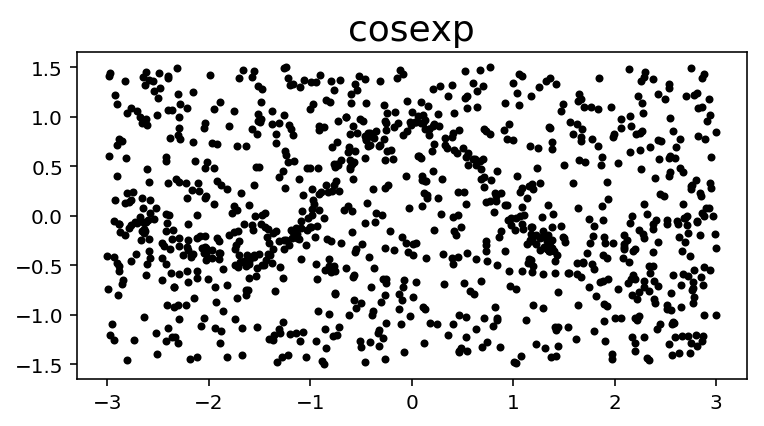

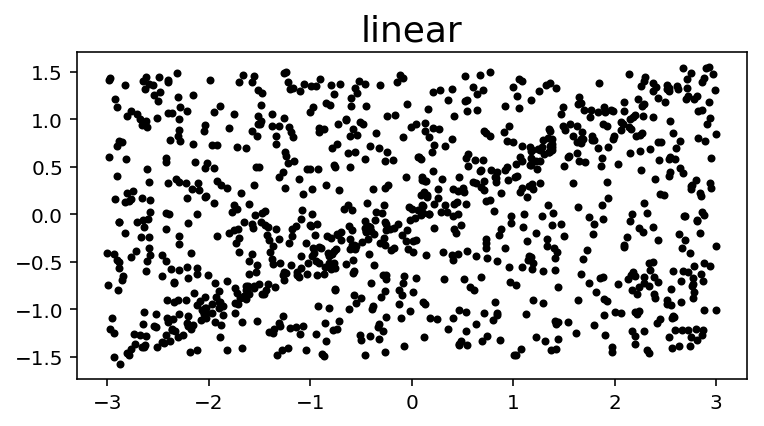

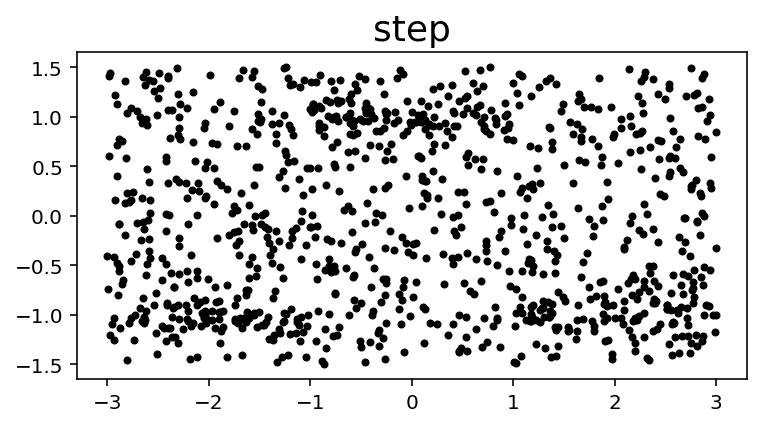

In [10]:
def f_cosexp(x): return np.cos(np.pi/2*x)*np.exp(-(x/2)**2)
def f_linear(x): return 0.5*x
def f_step(x):
    n = x.shape[0]
    t = np.zeros(shape=(n,1))
    for i in range(n):
        if x[i] < -1: t[i] = -1.0
        elif x[i] < +1: t[i] = +1.0
        else: t[i] = -1.0
    return t
def data4reg(_type='',_n=1000,_oRange=[-1.5,+1.5],_oRate=0.1,measVar=0.01):
    np.random.seed(seed=0) # Fix random seed
    _xmin,_xmax = -3,+3
    x = np.float32(np.random.uniform(_xmin,_xmax,((int)(_n),1)))
    x.sort(axis=0)
    if _type == 'cosexp': t = f_cosexp(x)
    elif _type == 'linear': t = f_linear(x)
    elif _type == 'step': t = f_step(x)
    else: print ("Unknown function type [%s]."%(_type))
    # Add measurement nosie
    y = t + np.sqrt(measVar)*np.random.randn(_n,1)
    # Switch to outliers 
    nOutlier = (int)(_n*_oRate) # Number of outliers
    y[np.random.permutation((int)(_n))[:nOutlier],:] \
        = _oRange[0]+np.random.rand(nOutlier,1)*(_oRange[1]-_oRange[0])
    return x,y,t
def plot_1dRegData(_x,_y,_t,_type='',_figSize=(6,3)):
    plt.figure(figsize=_figSize) # Plot
    # ht,=plt.plot(_x,_t,'ro')
    hd,=plt.plot(_x,_y,'k.')
    # plt.legend([ht,hd],['Target function','Training data'],fontsize=15)
    plt.title('%s'%(_type),fontsize=18)
    plt.show()
# Demo Usage 
if __name__ == "__main__":
    for tIdx,_type in enumerate(['cosexp','linear','step']):
        _x,_y,_t=data4reg(_type=_type,_n=1000,_oRange=[-1.5,+1.5],_oRate=0.8,measVar=1e-2)
        plot_1dRegData(_x,_y,_t,_type)
        

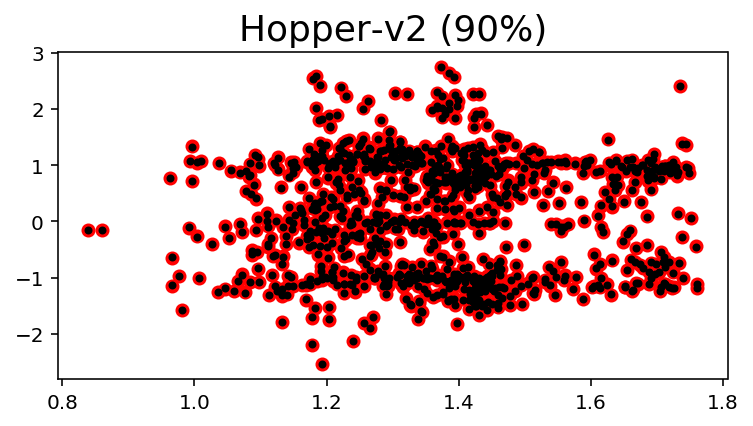

In [11]:
from sklearn.utils import shuffle
import pickle

def data4imitation_expert_crazy(envname='HalfCheetah-v2',_n = 1000,_oRate=[0.5,0.5],measVar=0.0001):
    np.random.seed(seed=0) # Fix random seed
    with open('./demos/'+envname+'-expert.pkl', 'rb') as f:
        data1 = pickle.load(f)[0]
    with open('./demos/'+envname+'-crazy.pkl', 'rb') as f:
        data3 = pickle.load(f)[0]

    x1 = np.concatenate([d['observes'] for d in data1])
    x3 = np.concatenate([d['observes'] for d in data3])
    t1 = np.concatenate([d['actions'][:,0] for d in data1])
    t3 = np.concatenate([d['actions'][:,0] for d in data3])

    _n1 = (int)(_n*_oRate[0])
    _n3 = (int)(_n*_oRate[1])
    
    x1, t1 = shuffle(x1, t1, random_state=0)
    x3, t3 = shuffle(x3, t3, random_state=0)
    x = np.concatenate((x1[:_n1,:],x3[:_n3,:]))
    t = np.concatenate((t1[:_n1,:],t3[:_n3,:]))
    t_dim = t.shape[1]

    y = t + np.sqrt(measVar)*np.random.randn(_n,t_dim)
    return x,y,t

def data4imitation(envname='HalfCheetah-v2',_n = 1000,_oRange=[-1.5,+1.5],_oRate=[0.7,0.2,0.1],measVar=0.0001):
    np.random.seed(seed=0) # Fix random seed
    with open('./demos/'+envname+'-expert.pkl', 'rb') as f:
        data1 = pickle.load(f)[0]
    with open('./demos/'+envname+'-novice.pkl', 'rb') as f:
        data2 = pickle.load(f)[0]
    with open('./demos/'+envname+'-crazy.pkl', 'rb') as f:
        data3 = pickle.load(f)[0]

    x1 = np.concatenate([d['observes'] for d in data1])
    x2 = np.concatenate([d['observes'] for d in data2])
    x3 = np.concatenate([d['observes'] for d in data3])
    t1 = np.concatenate([d['actions'][:,0] for d in data1])
    t2 = np.concatenate([d['actions'][:,0] for d in data2])
    t3 = np.concatenate([d['actions'][:,0] for d in data3])

    _n1 = (int)(_n*_oRate[0])
    _n2 = (int)(_n*_oRate[1])
    _n3 = (int)(_n*_oRate[2])
    
    x1, t1 = shuffle(x1, t1, random_state=0)
    x2, t2 = shuffle(x2, t2, random_state=0)
    x3, t3 = shuffle(x3, t3, random_state=0)
    x = np.concatenate((x1[:_n1,:],x2[:_n2,:],x3[:_n3,:]))
    t = np.concatenate((t1[:_n1,:],t2[:_n2,:],t3[:_n3,:]))
    t_dim = t.shape[1]

    y = t + np.sqrt(measVar)*np.random.randn(_n,t_dim)
    return x,y,t

def data4imitation_noisy(envname='HalfCheetah-v2',_n = 1000,_oRange=[-1.5,+1.5],_oRate=0.1,measVar=0.0001):
    np.random.seed(seed=0) # Fix random seed
    with open('./demos/'+envname+'-expert.pkl', 'rb') as f:
        data = pickle.load(f)[0]

    x = np.concatenate([d['observes'] for d in data])
    t = np.concatenate([d['actions'][:,0] for d in data])

    x, t = shuffle(x, t, random_state=0)
    x = x[:_n,:]
    t = t[:_n,:]
    t_dim = t.shape[1]

    nOutlier = (int)(_n*_oRate)
    y = t + np.sqrt(measVar)*np.random.randn(_n,t_dim)
    y[np.random.permutation((int)(_n))[:nOutlier],:] = _oRange[0]+np.random.rand(nOutlier,t_dim)*(_oRange[1]-_oRange[0])
    return x,y,t

def plot_1dRegData(_x,_y,_t,_type='',_figSize=(6,3)):
    plt.figure(figsize=_figSize) # Plot
    ht,=plt.plot(_x,_t,'ro')
    hd,=plt.plot(_x,_y,'k.')
    # plt.legend([ht,hd],['Target function','Training data'],fontsize=15)
    plt.title('%s'%(_type),fontsize=18)
    plt.show()

if __name__ == "__main__":
#     x,y,t=data4imitation_noisy(_oRate=0.1)
#     plot_1dRegData(x[:,0],y[:,0],t[:,0],'HalfCheetah-v2 (90%)')
    
    x,y,t=data4imitation_expert_crazy(envname='Hopper-v2',_oRate=[0.9,0.1])
    plot_1dRegData(x[:,0],y[:,0],t[:,0],'Hopper-v2 (90%)')
    
#     x,y,t=data4imitation_expert_crazy(_oRate=[0.7,0.3])
#     plot_1dRegData(x[:,0],y[:,0],t[:,0],'HalfCheetah-v2 (70%)')
    
#     x,y,t=data4imitation_expert_crazy(_oRate=[0.5,0.5])
#     plot_1dRegData(x[:,0],y[:,0],t[:,0],'HalfCheetah-v2 (50%)')

#     x,y,t=data4imitation_noisy(envname='Hopper-v2',_oRate=0.5)
#     plot_1dRegData(x[:,0],y[:,0],t[:,0],'Hopper-v2 (50%)')

    

### Mixup

In [12]:
def mixup(data, targets, alpha):
    # Pick corresponding data samples
    n = data.shape[0]
    indices = np.random.permutation(n)
    data2 = data[indices,:]
    targets2 = targets[indices,:]
    # Sample mix ratio from a Best distribution (0.0 to 1.0)
    lam = np.random.beta(alpha,alpha,size=(n,1))
    # Do mixup
    data = data * lam + data2 * (1 - lam)
    targets = targets * lam + targets2 * (1 - lam)
    return data, targets

### Helper Function for Classification Results Visualization

In [13]:
def extract_percent(_tokens,_key):
    _selItem = [x for x in _tokens if (_key in x) & ('%' in x)][0]
    _selItem = _selItem.replace(_key,'')
    _selItem = _selItem.replace(':','')
    _selItem = _selItem.replace('%','')
    return (float)(_selItem) 
def plot_mnist_accuracy(_Accrs,_txtList,_title='Accuracy'):
    plt.figure(figsize=(8,5))
    _cmap = plt.get_cmap('gist_rainbow')
    _nConfig = _Accrs.shape[0] # Number of configurations
    _colors = [_cmap(i) for i in np.linspace(0,1,_nConfig)]
    _max_cEpoch = 0
    for i in range(_nConfig): # For different configurations
        _cAccrs = _Accrs[i,:]
        _cEpoch = np.where(_cAccrs==0)[0][0]
        if _cEpoch>_max_cEpoch: _max_cEpoch=_cEpoch
        _cAccrs = _cAccrs[:_cEpoch] # Trim non-zero
        _fName = _txtList[i] 
        _fNameRfn = _fName.replace('../res/res_mnist_','') # Remove header 
        _fNameRfn = _fNameRfn.replace('.txt','') # Remove .txt 
        if 'mcdn' in _fNameRfn: _ls = '-' # Solid line for MCDN
        else: _ls = '--' # Dotted line for CNN 
        plt.plot(_cAccrs,label=_fNameRfn,color=_colors[i],lw=2,ls=_ls,marker='')
    plt.xlim([0,_max_cEpoch])
    plt.ylim([0,100])
    plt.grid(b=True)
    plt.title(_title,fontsize=20);
    #plt.legend(fontsize=12,loc='lower left')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=2)
    plt.xlabel('Epoch',fontsize=15);plt.ylabel('Accuracy [%]',fontsize=15)
    plt.show()
# Parse accuracies
def parse_accuracies(_txtList):
    nConfig = len(_txtList) # Number of configurations
    trainAccrs = np.zeros(shape=(nConfig,(int)(1e3)))
    testAccrs = np.zeros(shape=(nConfig,(int)(1e3)))
    valAccrs = np.zeros(shape=(nConfig,(int)(1e3)))
    for fIdx,fName in enumerate(_txtList):
        nEpoch = sum(1 for line in open(fName)) # Number of epochs
        for lIdx,eachLine in enumerate(open(fName,'r')): # For each line
            if lIdx==0: continue
            trainAccr = extract_percent(eachLine.split(' '),'train')
            testAccr = extract_percent(eachLine.split(' '),'test')
            valAccr = extract_percent(eachLine.split(' '),'val')
            trainAccrs[fIdx,lIdx-1] = trainAccr
            testAccrs[fIdx,lIdx-1] = testAccr
            valAccrs[fIdx,lIdx-1] = valAccr
            fNameRfn = fName.replace('../res/res_mnist_','')
            fNameRfn = fNameRfn.replace('.txt','')  
    return trainAccrs,testAccrs,valAccrs
def plot_accuracies(_mode='rp',_errRate=0):
    txtList = sorted(glob.glob('../res/res_mnist_%s_err%d*'%(_mode,_errRate)))
    print ("[%d] TXT load."%len(txtList))
    trainAccrs,testAccrs,valAccrs = parse_accuracies(_txtList=txtList)
    print ("Accuracies parsed.")
    # Plot acuuracies
    if _mode == 'rp': expType = 'Permutattion';_errRate /= 2
    elif _mode == 'rs': expType = 'Shuffle'
    elif _mode == 'b' : expType = 'Bised';_errRate /= 2
    
    plot_mnist_accuracy(trainAccrs,txtList,_title='[%s %d%%] Training Accuracy'%(expType,_errRate))
    plot_mnist_accuracy(testAccrs,txtList,_title='[%s %d%%] Test Accuracy'%(expType,_errRate))
    plot_mnist_accuracy(valAccrs,txtList,_title='[%s %d%%] Validation Accuracy'%(expType,_errRate))
    
def plot_mnist_accuracies(_mode='rs',_errRate=0,_SAVE_PNG=False):
    # Load 
    txtList = sorted(glob.glob('../res/res_mnist_%s_err%d*'%(_mode,_errRate)))
    # print (txtList)
    trainAccrs,testAccrs,_ = parse_accuracies(_txtList=txtList)
    maxEpoch = np.where(trainAccrs[0,:]==0)[0][0]
    if _mode == 'rs':
        _errType = 'Random Shuffle'
    elif _mode == 'rp':
        _errType = 'Permutation'; _errRate /= 2
    elif _mode == 'b':
        _errType = 'Label Bias'; _errRate /= 2
    else:
        print ("Unkown mode:[%s]")
    if trainAccrs.shape[0] == 1: 
        print ('\n\n************************************')
        print ('%d%% %s is NOT ready.'%(_errRate,_errType))
        print ('************************************\n\n')
        return
    # Plot
    plt.figure(figsize=(7,4))
    # CNN train (k--)
    cnnTr,=plt.plot(trainAccrs[1,:maxEpoch],label='ConvNet (train)',color='k',lw=2,ls='--',marker='')
    # CNN test (k-)
    cnnTe,=plt.plot(testAccrs[1,:maxEpoch],label='ConvNet (test)',color='k',lw=2,ls='-',marker='')
    # ChoiceNet train (b--)
    chTr,=plt.plot(trainAccrs[0,:maxEpoch],label='ChoiceNet (train)',color='b',lw=2,ls='--',marker='')
    # ChoiceNet test (b-)
    chTe,=plt.plot(testAccrs[0,:maxEpoch],label='ChoiceNet (test)',color='b',lw=2,ls='-',marker='')
    # Misc
    plt.xlim([0,maxEpoch])
    plt.ylim([0,100])
    plt.legend(handles=[chTr,chTe,cnnTr,cnnTe],loc='lower center',shadow=True,ncol=2,fontsize=10.5)
    plt.xlabel('Number of Epochs',fontsize=15);plt.ylabel('Accuracy (%)',fontsize=13)
    plt.title('%d%% %s'%(_errRate,_errType),fontsize=13)
    # Save image
    if _SAVE_PNG:
        saveName = '../fig/fig_mnistRes_%s_%d.png'%(_mode,_errRate)
        plt.savefig(saveName); plt.show()
        print ("%s saved."%(saveName))
    else:
        plt.show()
    # Print out
    bestTestChoiceNet = np.max(testAccrs[0,:maxEpoch])
    finalTestChoiceNet = testAccrs[0,maxEpoch-1]
    bestTestConvNet = np.max(testAccrs[1,:maxEpoch])
    finalTestConvNet = testAccrs[1,maxEpoch-1]
    print ('%d%% %s (maxEpoch:%d)'%(_errRate,_errType,maxEpoch))
    # ConvNet
    print ("  ConvNet: Best: %.2f Last: %.2f"%(bestTestConvNet,finalTestConvNet))
    # ChoiceNet
    print ("ChoiceNet: Best: %.2f Last: %.2f"%(bestTestChoiceNet,finalTestChoiceNet))